In [1]:
from IPython.display import clear_output
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# raw_data
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
clear_output()

In [3]:
# filtering
raw_text = open('input.txt', 'r').read().lower()
keep_chars = [chr(i) for i in range(ord('a'), ord('z')+1)] + ["'", '-', ':', ';', ',', '.']
for c in set(raw_text):
    if c not in keep_chars:
        raw_text = raw_text.replace(c, ' ')
raw_text = ' '.join(raw_text.split())

# vocab
mask_token = '^'
pad_token  = '>'
vocab = [mask_token] + sorted(list(set(raw_text))) + [pad_token]
char_to_int = {c : i for i, c in enumerate(vocab)}
int_to_char = {i : c for c, i in char_to_int.items()}

In [4]:
def _encode(seq):
    if len(seq[0]) == 1:
        return [char_to_int[c] for c in seq]
    res = []
    for s in seq:
        res.append(_encode(s))
    return res

def encode(seq):
    return torch.tensor(_encode(seq))

def decode(tokens):
    return [int_to_char[i.item()] for i in tokens.cpu()]

mask_prob = torch.tensor([0.15, 0.85])
def mask_tokens(tokens, pad, mask_prob=mask_prob):
    mask = torch.multinomial(mask_prob, tokens.shape[-1], replacement=True)
    mask = torch.where(pad==0, mask, pad)
    return tokens * mask, mask

corrupt_prob = torch.tensor([0.075, 0.85, 0.075]) # 0 => mask, 1 => keep, 2 => corrupt
def corrupt_tokens(tokens, pad, corrupt_prob=corrupt_prob):
    mask = torch.multinomial(corrupt_prob, tokens.shape[-1], replacement=True)
    mask = mask.masked_fill(pad==1, 1) # keep pad
    #masking <0>
    corrupted_tokens = tokens.masked_fill(mask==0, char_to_int[mask_token])
    #corrupting <1>
    tmp = torch.randint(high=len(vocab)-2, size=(tokens.shape[-1],))+1
    corrupted_tokens = torch.where(mask==2, tmp, corrupted_tokens)
    mask = mask.masked_fill(mask==2, 0)
    return corrupted_tokens, mask


num_words = 5
# max_len = 32
max_len = 48
def split_pad_trim(text, num_words=num_words, max_len=max_len):
    words = text.split()
    res = []
    pad_mask = []
    for i in range(0, len(words), num_words):
        s =' '.join(words[i:i+num_words])
        s_len = min(len(s), max_len)
        p_mask = [0] * s_len + [1] * (max_len - s_len)
        s += pad_token * max_len
        s = s[:max_len]
        res.append(s)
        pad_mask.append(p_mask)
    return res, pad_mask

In [5]:
class CharData(Dataset):
    def __init__(self, data, pad, mask_fn=mask_tokens):
        super().__init__()
        self.data = encode(data)
        self.pad = torch.tensor(pad)
        self.mask_fn = mask_fn
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        y = self.data[idx]
        pad = self.pad[idx]
        x, x_mask = self.mask_fn(y, pad)
        return x, x_mask, pad, y

In [6]:
batch_size = 256
lr = 1e-3

In [7]:
data, pad = split_pad_trim(raw_text)

X_train, X_test, pad_train, pad_test = train_test_split(data, pad, train_size=0.995)

train_dataset = CharData(X_train, pad_train, corrupt_tokens)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CharData(X_test, pad_test, corrupt_tokens)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'train size: {len(train_dataloader)}')
print(f'test size: {len(test_dataloader)}')

train size: 158
test size: 1


In [8]:
class Head(nn.Module):
    def __init__(self, model_dim, head_dim):
        super().__init__()
        self.Q = nn.Linear(model_dim, head_dim)
        self.K = nn.Linear(model_dim, head_dim)
        self.V = nn.Linear(model_dim, head_dim)
        
    def forward(self, x, pad=None):
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        
        _, _, D = x.shape
        scores = q @ k.transpose(-2,-1) * D**-0.5
        if pad is not None:
            scores = scores.masked_fill(pad==1, float('-inf'))
        
        w = F.softmax(scores, dim=-1)
        return w @ v
    
class MHSA(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=0.1):
        super().__init__()
        assert(model_dim % num_heads == 0)
        head_dim = model_dim // num_heads
        self.heads = nn.ModuleList([Head(model_dim, head_dim) for _ in range(num_heads)])
        self.proj = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, pad=None):
        x = torch.cat([h(x, pad) for h in self.heads], dim=-1)
        x = self.dropout(self.proj(x))
        return x
    
class FF(nn.Module):
    def __init__(self, model_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(model_dim, model_dim * 4),
            nn.ReLU(),
            nn.Linear(model_dim * 4, model_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    def __init__(self, model_dim, num_heads, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(model_dim)
        self.mhsa = MHSA(model_dim, num_heads, dropout)
        self.ln2 = nn.LayerNorm(model_dim)
        self.ff = FF(model_dim, dropout)
        
    def forward(self, x, pad=None):
        x = x + self.mhsa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x, pad
    
class CharTransformer(nn.Module):
    def __init__(self, num_layers, vocab_size, max_seq_len, model_dim, num_heads, dropout):
        super().__init__()
        self.char_embed = nn.Embedding(vocab_size, model_dim)
        self.pos_embed  = nn.Embedding(max_seq_len, model_dim)
        
        self.net = nn.ModuleList([Block(model_dim, num_heads, dropout) for _ in range(num_layers)])
        self.final_ln = nn.LayerNorm(model_dim)
        self.MLM_head = nn.Linear(model_dim, vocab_size)
        
    def forward(self, x, x_mask=None, pad=None, y=None):
        x = self.char_embed(x)
        x += self.pos_embed(torch.arange(x.shape[-2], device=x.device))
        for l in self.net:
            x, _ = l(x, pad)
        x = self.final_ln(x)
        logits = self.MLM_head(x)
        
        B, T, C = logits.shape
        
        if y is None:
            loss = None
        else:
            if x_mask is not None:
                masked_logits = logits.reshape(-1, C)
                masked_y = y.reshape(-1)
                masked_idx = torch.argwhere(x_mask.view(-1) - 1).view(-1)
                masked_logits, masked_y = masked_logits[masked_idx], masked_y[masked_idx]
                loss = F.cross_entropy(masked_logits, masked_y)
            elif pad is not None:
                unpadded_logits = logits.reshape(-1, C)
                unpadded_y = y.reshape(-1)
                unpadded_idx = torch.argwhere(pad.view(-1)-1).view(-1)
                unpadded_logits, unpadded_y = unpadded_logits[unpadded_idx], unpadded_y[unpadded_idx]
                loss = F.cross_entropy(unpadded_logits, unpadded_y)
            else:
                loss = F.cross_entropy(logits.view(-1,C), y.view(-1))
                
        return logits, loss
    
    def unmask(self, x, pad=None):
        logits, _ = self.forward(x, pad)
        B, T, C = logits.shape
        probs = F.softmax(logits, dim=-1)
#         preds = torch.multinomial(probs.view(-1, C), 1, replacement=True)
        preds = torch.argmax(probs.view(-1, C), dim=-1)
        preds[torch.argwhere(pad.view(-1)).view(-1)] = char_to_int[pad_token]
        return preds.reshape(B, T)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_layers = 6
vocab_size = len(vocab)
max_seq_len = max_len
model_dim = 32
num_heads = 4
dropout = 0.1
model = CharTransformer(num_layers, vocab_size, max_seq_len, model_dim, num_heads, dropout).to(device)
print(f"model size: {sum([p.numel() for p in model.parameters()])}")
optimizer = optim.Adam(model.parameters(), lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, verbose=True)

model size: 80099


In [10]:
test_loss_hist = []
train_loss_hist = []
corrupt_position_stat = torch.zeros((max_seq_len,), dtype=torch.long)

In [11]:
num_epoch = 50

for epoch in range(num_epoch):
    with torch.no_grad():
        x, x_mask, pad, y = next(iter(test_dataloader))
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        _, test_loss = model(x, x_mask, pad, y)
        x, x_mask, pad, y = next(iter(train_dataloader))
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        _, train_loss = model(x, x_mask, pad, y)
        print(f'Epoch {epoch}. Train: {train_loss.cpu().item():.2f}, test : {test_loss.cpu().item():.2f}')
        test_loss_hist.append(test_loss.cpu().item())
        train_loss_hist.append(train_loss.cpu().item())
    
    for x, x_mask, pad, y in tqdm(train_dataloader, total=len(train_dataloader)):
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        optimizer.zero_grad()
        logits, loss = model(x, x_mask, pad, y)
        loss.backward()
        optimizer.step()
        corrupt_position_stat -= (x_mask-1).sum(dim=0).cpu()
    lr_scheduler.step(test_loss)

Epoch 0. Train: 3.73, test : 3.71


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 1. Train: 3.00, test : 2.99


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 2. Train: 2.88, test : 2.84


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 3. Train: 2.93, test : 2.83


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 4. Train: 2.84, test : 2.78


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 5. Train: 2.81, test : 2.82


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 6. Train: 2.72, test : 2.67


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 7. Train: 2.62, test : 2.53


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 8. Train: 2.53, test : 2.52


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 9. Train: 2.42, test : 2.49


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 10. Train: 2.30, test : 2.26


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 11. Train: 2.25, test : 2.25


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 12. Train: 2.27, test : 2.19


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 13. Train: 2.21, test : 2.11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 14. Train: 2.20, test : 2.10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 15. Train: 2.08, test : 2.06


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 16. Train: 2.03, test : 2.05


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 17. Train: 2.03, test : 2.09


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 18. Train: 2.08, test : 2.03


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 19. Train: 1.99, test : 1.90


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 20. Train: 2.04, test : 1.96


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 21. Train: 1.96, test : 1.89


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 22. Train: 1.94, test : 1.95


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 23. Train: 1.98, test : 1.92


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 24. Train: 1.91, test : 1.87


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 25. Train: 1.97, test : 1.72


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 26. Train: 1.78, test : 1.77


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 27. Train: 1.84, test : 1.79


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 28. Train: 1.86, test : 1.79


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 29. Train: 1.89, test : 1.77


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 30. Train: 1.79, test : 1.73


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 31. Train: 1.80, test : 1.69


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 32. Train: 1.83, test : 1.63


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 33. Train: 1.78, test : 1.75


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 34. Train: 1.81, test : 1.79


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 35. Train: 1.73, test : 1.67


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 36. Train: 1.88, test : 1.66


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 37. Train: 1.68, test : 1.75


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 38. Train: 1.77, test : 1.69


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 39. Train: 1.74, test : 1.65


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 40. Train: 1.76, test : 1.70


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 41. Train: 1.76, test : 1.68


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 42. Train: 1.76, test : 1.74


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 43. Train: 1.66, test : 1.68


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 44. Train: 1.75, test : 1.65


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 45. Train: 1.67, test : 1.64


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 46. Train: 1.69, test : 1.68


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 47. Train: 1.65, test : 1.60


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 48. Train: 1.69, test : 1.68


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 49. Train: 1.62, test : 1.61


  0%|          | 0/158 [00:00<?, ?it/s]

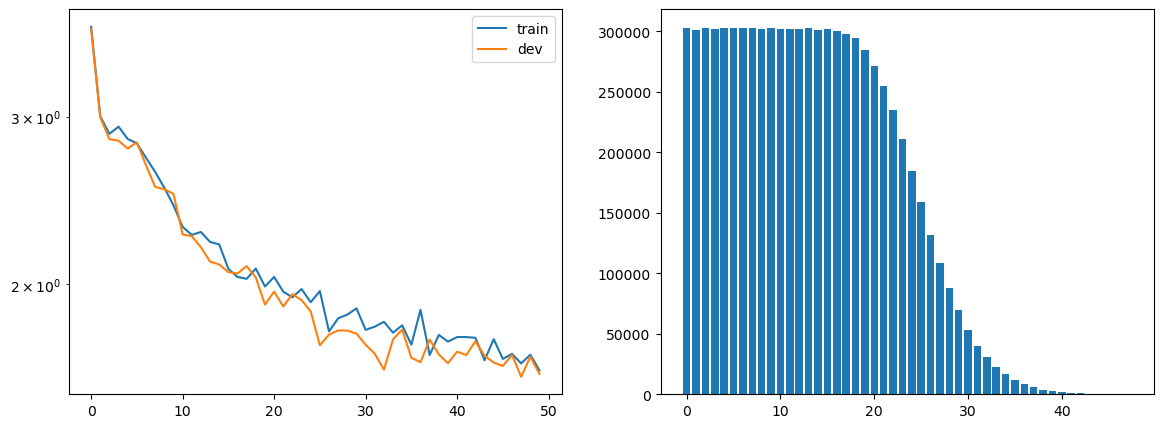

In [12]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,5)
ax[0].plot(train_loss_hist, label='train')
ax[0].plot(test_loss_hist, label='dev')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].bar(np.arange(max_seq_len), corrupt_position_stat.numpy());

In [13]:
model.eval()
with torch.no_grad():
    x, x_mask, pad, y = next(iter(test_dataloader))
    x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
    preds = model.unmask(x, pad).cpu()
    y = y.cpu()
    x = x.cpu()

for targ, corrupt, targ_mask, pred in zip(y, x, x_mask, preds[:30]):
    print('target_:',''.join(decode(targ)))
    print('corrupt:',''.join(decode(corrupt)))
    print('predict:',''.join(decode(pred)))
    print('unmask_:',''.join(decode(torch.where(targ_mask==1,pred,trag))))
    print('-'*57)

target_: are he may, let me>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
corrupt: are he mat, let me>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
predict: are he huyh hot my>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: himself and to live without>>>>>>>>>>>>>>>>>>>>>
corrupt: himselfvand to ^ive with^ub>>>>>>>>>>>>>>>>>>>>>
predict: mistel  and to lake with sr>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: ho romeo: what hast thou>>>>>>>>>>>>>>>>>>>>>>>>
corrupt: ho romef: what hast ^^ou>>>>>>>>>>>>>>>>>>>>>>>>
predict: te cones, that hise thow>>>>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: harm. king edward iv: then>>>>>>>>>>>>>>>>>>>>>>
corrupt: harm. ^ing e^wardkiv: then>>>>>>>>>>>>>>>>>>>>>>
predict: metee king adwar  eoe thee>>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: menenius: having determined of the>>>>>>>>>>>>>>
corrupt: menen

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.5e-03
num_layers = 6
vocab_size = len(vocab)
max_seq_len = max_len
model_dim = 64
num_heads = 4
dropout = 0.1
model = CharTransformer(num_layers, vocab_size, max_seq_len, model_dim, num_heads, dropout).to(device)
print(f"model size: {sum([p.numel() for p in model.parameters()])}")
optimizer = optim.Adam(model.parameters(), lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, verbose=True, min_lr=1e-7)

model size: 307619


In [15]:
test_loss_hist = []
train_loss_hist = []
corrupt_position_stat = torch.zeros((max_seq_len,), dtype=torch.long)

In [16]:
num_epoch = 350

for epoch in range(num_epoch):
    with torch.no_grad():
        x, x_mask, pad, y = next(iter(test_dataloader))
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        _, test_loss = model(x, x_mask, pad, y)
        x, x_mask, pad, y = next(iter(train_dataloader))
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        _, train_loss = model(x, x_mask, pad, y)
        print(f'Epoch {lr_scheduler.last_epoch}. Train: {train_loss.cpu().item():.2f}, test : {test_loss.cpu().item():.2f}, bad_epochs: {lr_scheduler.num_bad_epochs}')
        test_loss_hist.append(test_loss.cpu().item())
        train_loss_hist.append(train_loss.cpu().item())
    
    for x, x_mask, pad, y in tqdm(train_dataloader, total=len(train_dataloader)):
        x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
        optimizer.zero_grad()
        logits, loss = model(x, x_mask, pad, y)
        loss.backward()
        optimizer.step()
        corrupt_position_stat -= (x_mask-1).sum(dim=0).cpu()
    lr_scheduler.step(test_loss)

Epoch 0. Train: 3.75, test : 3.78, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 1. Train: 2.97, test : 2.89, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 2. Train: 2.92, test : 2.90, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 3. Train: 2.84, test : 2.80, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 4. Train: 2.77, test : 2.74, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 5. Train: 2.62, test : 2.57, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 6. Train: 2.31, test : 2.18, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 7. Train: 2.22, test : 2.15, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 8. Train: 2.12, test : 2.07, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 9. Train: 2.03, test : 2.03, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 10. Train: 2.05, test : 1.96, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 11. Train: 1.92, test : 1.78, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 12. Train: 1.91, test : 1.82, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 13. Train: 1.90, test : 1.86, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 14. Train: 1.83, test : 1.71, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 15. Train: 1.76, test : 1.74, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 16. Train: 1.78, test : 1.79, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 17. Train: 1.73, test : 1.73, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 18. Train: 1.71, test : 1.70, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 19. Train: 1.68, test : 1.63, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 20. Train: 1.68, test : 1.54, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 21. Train: 1.76, test : 1.61, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 22. Train: 1.65, test : 1.59, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 23. Train: 1.59, test : 1.55, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 24. Train: 1.61, test : 1.54, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 25. Train: 1.66, test : 1.52, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 26. Train: 1.54, test : 1.49, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 27. Train: 1.50, test : 1.51, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 28. Train: 1.52, test : 1.43, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 29. Train: 1.58, test : 1.41, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 30. Train: 1.50, test : 1.45, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 31. Train: 1.49, test : 1.52, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 32. Train: 1.46, test : 1.43, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 33. Train: 1.43, test : 1.33, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 34. Train: 1.49, test : 1.41, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 35. Train: 1.52, test : 1.50, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 36. Train: 1.52, test : 1.26, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 37. Train: 1.52, test : 1.37, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 38. Train: 1.48, test : 1.28, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 39. Train: 1.39, test : 1.35, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 40. Train: 1.41, test : 1.38, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 41. Train: 1.38, test : 1.29, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 42. Train: 1.38, test : 1.40, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 43. Train: 1.32, test : 1.28, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 44. Train: 1.42, test : 1.31, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 45. Train: 1.42, test : 1.39, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 46. Train: 1.32, test : 1.34, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 47. Train: 1.40, test : 1.35, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 48. Train: 1.37, test : 1.30, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 49. Train: 1.39, test : 1.27, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 50. Train: 1.40, test : 1.34, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 51. Train: 1.29, test : 1.31, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 52. Train: 1.38, test : 1.20, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 53. Train: 1.34, test : 1.31, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 54. Train: 1.33, test : 1.28, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 55. Train: 1.35, test : 1.33, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 56. Train: 1.31, test : 1.25, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 57. Train: 1.33, test : 1.23, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 58. Train: 1.26, test : 1.30, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 59. Train: 1.28, test : 1.35, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 60. Train: 1.27, test : 1.28, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 61. Train: 1.18, test : 1.22, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 62. Train: 1.40, test : 1.24, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 63. Train: 1.29, test : 1.11, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 64. Train: 1.26, test : 1.22, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 65. Train: 1.23, test : 1.15, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 66. Train: 1.19, test : 1.17, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 67. Train: 1.28, test : 1.20, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 68. Train: 1.33, test : 1.28, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 69. Train: 1.30, test : 1.17, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 70. Train: 1.22, test : 1.24, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 71. Train: 1.20, test : 1.21, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 72. Train: 1.22, test : 1.23, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 73. Train: 1.32, test : 1.20, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 74. Train: 1.28, test : 1.19, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 75. Train: 1.26, test : 1.20, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 76. Train: 1.26, test : 1.21, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 77. Train: 1.29, test : 1.19, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 78. Train: 1.19, test : 1.17, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 79. Train: 1.32, test : 1.12, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00080: reducing learning rate of group 0 to 2.5000e-04.
Epoch 80. Train: 1.16, test : 1.06, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 81. Train: 1.19, test : 1.23, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 82. Train: 1.23, test : 1.17, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 83. Train: 1.24, test : 1.17, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 84. Train: 1.20, test : 1.20, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 85. Train: 1.18, test : 1.20, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 86. Train: 1.18, test : 1.18, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 87. Train: 1.24, test : 1.16, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 88. Train: 1.27, test : 1.15, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 89. Train: 1.16, test : 1.14, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 90. Train: 1.20, test : 1.19, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 91. Train: 1.20, test : 1.17, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 92. Train: 1.16, test : 1.17, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 93. Train: 1.15, test : 1.26, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 94. Train: 1.13, test : 1.26, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 95. Train: 1.23, test : 1.16, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 96. Train: 1.05, test : 1.14, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00097: reducing learning rate of group 0 to 1.2500e-04.
Epoch 97. Train: 1.28, test : 1.18, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 98. Train: 1.28, test : 1.16, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 99. Train: 1.21, test : 1.21, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 100. Train: 1.29, test : 1.19, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 101. Train: 1.10, test : 1.13, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 102. Train: 1.22, test : 1.11, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 103. Train: 1.11, test : 1.13, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 104. Train: 1.13, test : 1.09, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 105. Train: 1.05, test : 1.08, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 106. Train: 1.22, test : 1.06, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 107. Train: 1.18, test : 1.09, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 108. Train: 1.16, test : 1.10, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 109. Train: 1.25, test : 1.18, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 110. Train: 1.15, test : 1.19, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 111. Train: 1.18, test : 1.14, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 112. Train: 1.26, test : 1.10, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 113. Train: 1.14, test : 1.15, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 114. Train: 1.27, test : 1.09, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 115. Train: 1.13, test : 1.08, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 116. Train: 1.19, test : 1.17, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 117. Train: 1.18, test : 1.17, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 118. Train: 1.24, test : 1.10, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 119. Train: 1.20, test : 1.15, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 120. Train: 1.26, test : 1.11, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 121. Train: 1.20, test : 1.10, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 122. Train: 1.16, test : 1.14, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00123: reducing learning rate of group 0 to 6.2500e-05.
Epoch 123. Train: 1.29, test : 1.19, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 124. Train: 1.17, test : 1.08, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 125. Train: 1.17, test : 1.14, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 126. Train: 1.13, test : 1.05, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 127. Train: 1.13, test : 1.18, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 128. Train: 1.11, test : 1.07, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 129. Train: 1.09, test : 1.11, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 130. Train: 1.19, test : 1.10, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 131. Train: 1.07, test : 1.09, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 132. Train: 1.11, test : 1.12, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 133. Train: 1.18, test : 1.17, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 134. Train: 1.18, test : 1.21, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 135. Train: 1.13, test : 1.16, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 136. Train: 1.12, test : 1.17, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 137. Train: 1.13, test : 1.06, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 138. Train: 1.17, test : 1.05, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 139. Train: 1.14, test : 1.15, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 140. Train: 1.26, test : 1.12, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 141. Train: 1.16, test : 1.18, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 142. Train: 1.15, test : 1.15, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00143: reducing learning rate of group 0 to 3.1250e-05.
Epoch 143. Train: 1.18, test : 1.07, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 144. Train: 1.09, test : 1.14, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 145. Train: 1.05, test : 1.13, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 146. Train: 1.21, test : 1.10, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 147. Train: 1.19, test : 1.06, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 148. Train: 1.11, test : 1.21, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 149. Train: 1.14, test : 1.07, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 150. Train: 1.19, test : 0.99, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 151. Train: 1.17, test : 1.03, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 152. Train: 1.12, test : 1.14, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 153. Train: 1.15, test : 1.13, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 154. Train: 1.14, test : 1.22, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 155. Train: 1.15, test : 1.12, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 156. Train: 1.11, test : 1.11, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 157. Train: 1.18, test : 1.17, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 158. Train: 1.14, test : 1.09, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 159. Train: 1.10, test : 1.11, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 160. Train: 1.22, test : 1.06, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 161. Train: 1.15, test : 1.09, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 162. Train: 1.15, test : 1.04, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 163. Train: 1.11, test : 1.20, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 164. Train: 1.14, test : 1.22, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 165. Train: 1.20, test : 1.13, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 166. Train: 1.18, test : 1.19, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00167: reducing learning rate of group 0 to 1.5625e-05.
Epoch 167. Train: 1.14, test : 1.12, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 168. Train: 1.17, test : 1.03, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 169. Train: 1.17, test : 1.13, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 170. Train: 1.24, test : 1.04, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 171. Train: 1.07, test : 1.14, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 172. Train: 1.17, test : 0.97, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 173. Train: 1.13, test : 1.06, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 174. Train: 1.29, test : 1.16, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 175. Train: 1.15, test : 1.18, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 176. Train: 1.13, test : 1.04, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 177. Train: 1.15, test : 1.12, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 178. Train: 1.18, test : 1.09, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 179. Train: 1.17, test : 1.11, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 180. Train: 1.17, test : 1.17, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 181. Train: 1.11, test : 1.08, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 182. Train: 1.21, test : 1.02, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 183. Train: 1.09, test : 1.21, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 184. Train: 1.11, test : 1.06, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 185. Train: 1.15, test : 1.08, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 186. Train: 1.24, test : 1.08, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 187. Train: 1.10, test : 1.03, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 188. Train: 1.17, test : 1.09, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00189: reducing learning rate of group 0 to 7.8125e-06.
Epoch 189. Train: 1.22, test : 1.01, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 190. Train: 1.05, test : 1.11, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 191. Train: 1.22, test : 1.05, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 192. Train: 1.04, test : 1.05, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 193. Train: 1.21, test : 1.21, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 194. Train: 1.13, test : 1.11, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 195. Train: 1.15, test : 1.13, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 196. Train: 1.15, test : 1.20, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 197. Train: 1.22, test : 1.15, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 198. Train: 1.07, test : 1.24, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 199. Train: 1.13, test : 1.09, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 200. Train: 1.21, test : 1.08, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 201. Train: 1.13, test : 1.12, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 202. Train: 1.05, test : 1.11, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 203. Train: 1.13, test : 1.06, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 204. Train: 1.20, test : 1.04, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00205: reducing learning rate of group 0 to 3.9063e-06.
Epoch 205. Train: 1.12, test : 1.17, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 206. Train: 1.05, test : 1.04, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 207. Train: 1.08, test : 1.10, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 208. Train: 1.15, test : 1.21, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 209. Train: 1.17, test : 1.16, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 210. Train: 1.06, test : 1.19, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 211. Train: 1.22, test : 0.99, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 212. Train: 1.14, test : 1.12, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 213. Train: 1.16, test : 1.12, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 214. Train: 1.18, test : 1.13, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 215. Train: 1.03, test : 1.10, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 216. Train: 1.18, test : 1.13, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 217. Train: 1.05, test : 1.06, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 218. Train: 1.02, test : 1.23, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 219. Train: 1.10, test : 1.25, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 220. Train: 1.08, test : 1.13, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00221: reducing learning rate of group 0 to 1.9531e-06.
Epoch 221. Train: 1.11, test : 1.05, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 222. Train: 1.12, test : 1.01, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 223. Train: 1.05, test : 1.04, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 224. Train: 1.14, test : 1.09, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 225. Train: 1.12, test : 1.05, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 226. Train: 1.22, test : 0.96, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 227. Train: 1.12, test : 1.11, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 228. Train: 1.10, test : 1.14, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 229. Train: 1.09, test : 1.03, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 230. Train: 1.17, test : 1.19, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 231. Train: 1.07, test : 1.12, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 232. Train: 1.16, test : 1.18, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 233. Train: 1.17, test : 1.18, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 234. Train: 1.07, test : 1.13, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 235. Train: 1.11, test : 1.11, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 236. Train: 1.09, test : 1.03, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 237. Train: 1.19, test : 1.12, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 238. Train: 1.13, test : 1.05, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 239. Train: 1.20, test : 1.08, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 240. Train: 1.09, test : 1.14, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 241. Train: 1.11, test : 1.14, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 242. Train: 1.16, test : 1.09, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00243: reducing learning rate of group 0 to 9.7656e-07.
Epoch 243. Train: 1.14, test : 1.09, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 244. Train: 1.15, test : 1.09, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 245. Train: 1.09, test : 1.13, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 246. Train: 1.13, test : 1.09, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 247. Train: 1.18, test : 1.11, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 248. Train: 1.11, test : 1.10, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 249. Train: 1.08, test : 1.18, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 250. Train: 1.16, test : 1.17, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 251. Train: 1.13, test : 1.11, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 252. Train: 1.20, test : 1.12, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 253. Train: 1.15, test : 1.15, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 254. Train: 1.18, test : 1.12, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 255. Train: 1.08, test : 1.01, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 256. Train: 1.06, test : 1.10, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 257. Train: 1.11, test : 1.17, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 258. Train: 1.08, test : 1.04, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00259: reducing learning rate of group 0 to 4.8828e-07.
Epoch 259. Train: 1.05, test : 1.18, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 260. Train: 1.14, test : 1.04, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 261. Train: 1.09, test : 1.13, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 262. Train: 1.14, test : 1.07, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 263. Train: 1.26, test : 1.21, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 264. Train: 1.08, test : 1.12, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 265. Train: 1.20, test : 1.23, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 266. Train: 1.15, test : 1.10, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 267. Train: 1.11, test : 1.09, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 268. Train: 1.19, test : 1.20, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 269. Train: 1.12, test : 1.05, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 270. Train: 1.13, test : 0.98, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 271. Train: 1.13, test : 1.09, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 272. Train: 1.07, test : 1.12, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 273. Train: 1.18, test : 1.09, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 274. Train: 1.07, test : 1.03, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00275: reducing learning rate of group 0 to 2.4414e-07.
Epoch 275. Train: 1.14, test : 1.10, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 276. Train: 1.14, test : 1.15, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 277. Train: 1.17, test : 1.11, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 278. Train: 1.04, test : 1.01, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 279. Train: 1.11, test : 1.17, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 280. Train: 1.13, test : 1.07, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 281. Train: 1.17, test : 1.10, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 282. Train: 1.20, test : 1.07, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 283. Train: 1.17, test : 1.13, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 284. Train: 1.09, test : 1.12, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 285. Train: 1.10, test : 1.06, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 286. Train: 1.10, test : 1.18, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 287. Train: 1.08, test : 0.98, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 288. Train: 1.12, test : 1.14, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 289. Train: 1.05, test : 1.17, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 290. Train: 1.11, test : 1.05, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00291: reducing learning rate of group 0 to 1.2207e-07.
Epoch 291. Train: 1.10, test : 1.14, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 292. Train: 1.10, test : 1.09, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 293. Train: 1.16, test : 1.10, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 294. Train: 1.23, test : 1.13, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 295. Train: 1.12, test : 1.08, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 296. Train: 1.13, test : 1.18, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 297. Train: 1.19, test : 1.16, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 298. Train: 1.09, test : 1.16, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 299. Train: 1.17, test : 1.11, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 300. Train: 1.15, test : 1.02, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 301. Train: 1.15, test : 1.12, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 302. Train: 1.22, test : 1.09, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 303. Train: 1.22, test : 1.11, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 304. Train: 1.18, test : 1.15, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 305. Train: 1.12, test : 1.05, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 306. Train: 1.12, test : 1.17, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 00307: reducing learning rate of group 0 to 1.0000e-07.
Epoch 307. Train: 1.15, test : 1.14, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 308. Train: 1.16, test : 1.20, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 309. Train: 1.09, test : 1.12, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 310. Train: 1.14, test : 1.00, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 311. Train: 1.19, test : 1.10, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 312. Train: 1.18, test : 1.13, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 313. Train: 1.14, test : 0.97, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 314. Train: 1.08, test : 1.11, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 315. Train: 1.22, test : 1.11, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 316. Train: 1.13, test : 1.07, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 317. Train: 1.14, test : 1.18, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 318. Train: 1.13, test : 1.14, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 319. Train: 1.08, test : 1.11, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 320. Train: 1.19, test : 1.08, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 321. Train: 1.20, test : 1.16, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 322. Train: 1.22, test : 1.12, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 323. Train: 1.09, test : 1.12, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 324. Train: 1.15, test : 1.09, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 325. Train: 1.13, test : 1.18, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 326. Train: 1.11, test : 0.97, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 327. Train: 1.15, test : 1.12, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 328. Train: 1.17, test : 1.08, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 329. Train: 1.08, test : 1.09, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 330. Train: 1.15, test : 1.06, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 331. Train: 1.12, test : 1.07, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 332. Train: 1.08, test : 1.16, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 333. Train: 1.15, test : 1.12, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 334. Train: 1.04, test : 1.12, bad_epochs: 11


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 335. Train: 1.07, test : 1.15, bad_epochs: 12


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 336. Train: 1.24, test : 1.13, bad_epochs: 13


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 337. Train: 1.03, test : 1.08, bad_epochs: 14


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 338. Train: 1.14, test : 1.10, bad_epochs: 15


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 339. Train: 1.14, test : 1.16, bad_epochs: 0


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 340. Train: 1.14, test : 1.08, bad_epochs: 1


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 341. Train: 1.07, test : 1.11, bad_epochs: 2


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 342. Train: 1.08, test : 1.14, bad_epochs: 3


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 343. Train: 1.15, test : 1.02, bad_epochs: 4


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 344. Train: 1.20, test : 1.17, bad_epochs: 5


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 345. Train: 1.08, test : 1.14, bad_epochs: 6


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 346. Train: 1.20, test : 1.09, bad_epochs: 7


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 347. Train: 1.15, test : 1.09, bad_epochs: 8


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 348. Train: 1.09, test : 1.07, bad_epochs: 9


  0%|          | 0/158 [00:00<?, ?it/s]

Epoch 349. Train: 1.20, test : 1.17, bad_epochs: 10


  0%|          | 0/158 [00:00<?, ?it/s]

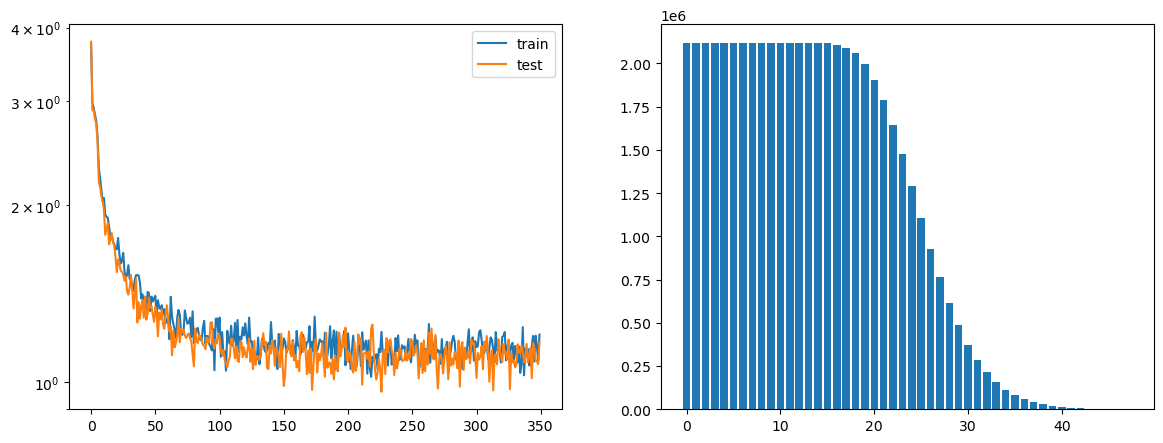

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,5)
ax[0].plot(train_loss_hist, label='train')
ax[0].plot(test_loss_hist, label='test')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].bar(np.arange(max_seq_len), corrupt_position_stat.numpy());

In [22]:
model.eval()
with torch.no_grad():
    x, x_mask, pad, y = next(iter(test_dataloader))
    x, x_mask, pad, y = x.to(device), x_mask.to(device), pad.to(device), y.to(device)
    preds = model.unmask(x, pad).cpu()
    y = y.cpu()
    x = x.cpu()
    x_mask = x_mask.cpu()

for targ, corrupt, targ_mask, pred in zip(y, x, x_mask, preds[:50]):
    print('target_:',''.join(decode(targ)))
    print('corrupt:',''.join(decode(corrupt)))
    print('predict:',''.join(decode(pred)))
    print('unmask_:',''.join(decode(torch.where(targ_mask==0,pred,targ))))
    print('-'*57)

target_: for he that interrupts him>>>>>>>>>>>>>>>>>>>>>>
corrupt: forhhe  h^l iptebruqss him>>>>>>>>>>>>>>>>>>>>>>
predict: forte,rtaomlanp rloee: his>>>>>>>>>>>>>>>>>>>>>>
unmask_: forthe thom interruees him>>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: thy bruising irons of wrath,>>>>>>>>>>>>>>>>>>>>
corrupt: thy bruising irons of^wratm,>>>>>>>>>>>>>>>>>>>>
predict: the toassing fpaus of fheiey>>>>>>>>>>>>>>>>>>>>
unmask_: thy bruising irons of wrate,>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: you sing, i'ld have you>>>>>>>>>>>>>>>>>>>>>>>>>
corrupt: you sing, ^'^dehave you>>>>>>>>>>>>>>>>>>>>>>>>>
predict: you kine, ionr have you>>>>>>>>>>>>>>>>>>>>>>>>>
unmask_: you sing, i'nd have you>>>>>>>>>>>>>>>>>>>>>>>>>
---------------------------------------------------------
target_: now am i seated as>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
corrupt: how ampi sea^ed as>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
predict: now i